In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.polynomial.chebyshev import chebval
from itertools import product

In [ ]:
class Zonotope:
    def __init__(self, centre, generators):
        self.centre = np.array(centre).reshape(-1)         # shape (n,)
        self.generators = np.atleast_2d(generators)        # shape (n, m)
        if self.generators.shape[0] != self.centre.shape[0]:
            raise ValueError("Generators must have same dimension as centre")
        self.d = self.centre.shape[0]   # dimension
        self.m = self.generators.shape[1]  # number of generators

    def minkowski_sum(self, other):
        new_centre = self.centre + other.centre
        new_generators = np.hstack((self.generators, other.generators))
        return Zonotope(new_centre, new_generators)
    
    def subtract(self, other):
        new_centre = self.centre - other.centre
        new_generators = np.hstack((self.generators, -other.generators))
        return Zonotope(new_centre, new_generators)
    
    @classmethod
    def from_intervals(cls, lower, upper):
        lower = np.array(lower).reshape(-1)
        upper = np.array(upper).reshape(-1)

        if lower.shape != upper.shape:
            raise ValueError("Lower and upper must have same shape")

        centre = (lower + upper) / 2
        radii = (upper - lower) / 2

        generators = np.diag(radii)
        return cls(centre, generators)
    
    def output_interval(self):
        radius = np.sum(np.abs(self.generators), axis=1)  # sum across generators
        lower = self.centre - radius
        upper = self.centre + radius
        return lower, upper

    def affine_map(self, A, b=None):
            # Ensure centre is a column vector for matrix multiplication
            new_centre = A @ self.centre
            if b is not None:
                new_centre = new_centre + np.array(b).reshape(-1)
            new_generators = A @ self.generators
            return Zonotope(new_centre, new_generators)
    
    def __repr__(self):
        return f"Zonotope(dim={self.d}, generators={self.m})\nCentre:\n{self.centre}\nGenerators:\n{self.generators}"

### Data

In [3]:
df = pd.read_csv('Data/FuelConsumption.csv')
df.head()

car_df = df[['CYLINDERS', 'ENGINE SIZE', 'FUEL', 'FUEL CONSUMPTION', 'COMB (mpg)', 'EMISSIONS']]
car_df.head()

rng = np.random.default_rng(42)  # reproducibility
y = car_df['EMISSIONS'].values

y_radius = np.abs(np.random.normal(2, 0.5, len(car_df)))
car_df['EMISSIONS_LOWER'] = y - y_radius
car_df['EMISSIONS_UPPER'] = y + y_radius


car_df.head()

/tmp/ipykernel_12587/3518267991.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['EMISSIONS_LOWER'] = y - y_radius
/tmp/ipykernel_12587/3518267991.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df['EMISSIONS_UPPER'] = y + y_radius


,CYLINDERS,ENGINE SIZE,FUEL,FUEL CONSUMPTION,COMB (mpg),EMISSIONS,EMISSIONS_LOWER,EMISSIONS_UPPER
0,4,1.6,X,9.2,35,186,184.050064,187.949936
1,4,1.6,X,8.5,37,175,172.969906,177.030094
2,6,3.2,Z,12.2,28,230,227.981823,232.018177
3,6,3.5,Z,13.4,25,264,261.900105,266.099895
4,4,1.8,X,10.0,33,198,196.102472,199.897528


In [ ]:
def multivariate_chebyshev_basis(X, degree=1):
    X = np.asarray(X)
    n_samples, n_features = X.shape

    X_std = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)
    X_scaled = np.clip(X_std, -1, 1)

    multi_indices = list(product(range(degree + 1), repeat=n_features))
    
    Phi_list = []
    for multi_idx in multi_indices:
        basis_term = np.ones(n_samples)
        for feature_idx, deg in enumerate(multi_idx):
            if deg > 0:
                coeffs = [0] * deg + [1]
                basis_term *= chebval(X_scaled[:, feature_idx], coeffs)
        Phi_list.append(basis_term)
    
    return np.column_stack(Phi_list)

def nonlinear_zonotope_bounds(
    X, y_lower, y_upper, Phi_grid=None, degree=2, regularization=1e-4
):
    X = np.asarray(X)
    y_lower = np.asarray(y_lower).reshape(-1)
    y_upper = np.asarray(y_upper).reshape(-1)

    Phi = multivariate_chebyshev_basis(X, degree)

    M = np.linalg.inv(Phi.T @ Phi + regularization * np.eye(Phi.shape[1])) @ Phi.T

    Y_zono = Zonotope.from_intervals(y_lower, y_upper)

    Beta_zono = Y_zono.affine_map(M)

    if Phi_grid is not None:
        Yhat_zono = Beta_zono.affine_map(Phi_grid)
        y_lower_pred, y_upper_pred = Yhat_zono.output_interval()
        return Beta_zono, Yhat_zono, y_lower_pred, y_upper_pred

    return Beta_zono

In [5]:
features = ['CYLINDERS', 'ENGINE SIZE', 'FUEL CONSUMPTION', 'COMB (mpg)']
X = car_df[features].values 

Phi_data = multivariate_chebyshev_basis(X, degree=3)

_, _, y_lower_pred, y_upper_pred = nonlinear_zonotope_bounds(
    X,
    car_df['EMISSIONS_LOWER'].values,
    car_df['EMISSIONS_UPPER'].values,
    Phi_grid=Phi_data,
    degree=3
)

y_centre_pred = 0.5 * (y_lower_pred + y_upper_pred)
y_centre_true = 0.5 * (car_df['EMISSIONS_LOWER'].values + car_df['EMISSIONS_UPPER'].values)



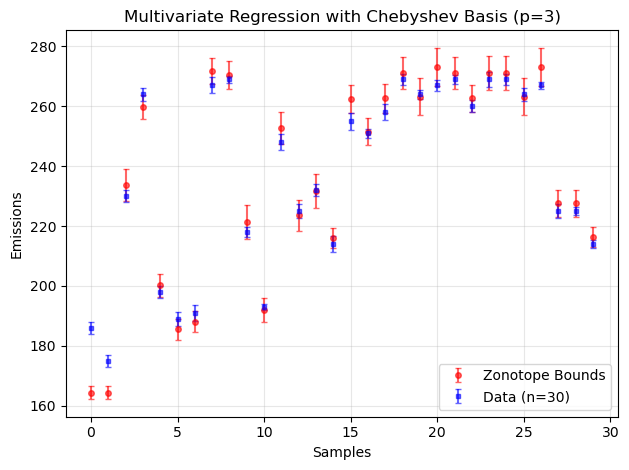

In [6]:

fig, ax = plt.subplots()

n_plot = min(30, len(y_centre_pred))
indices = np.arange(n_plot)

ax.errorbar(
    indices,
    y_centre_pred[:n_plot],
    yerr=[
        y_centre_pred[:n_plot] - y_lower_pred[:n_plot],
        y_upper_pred[:n_plot] - y_centre_pred[:n_plot]
    ],
    fmt='o',
    markersize=4,
    alpha=0.6,
    capsize=2,
    color='red',
    label='Zonotope Bounds'
)


ax.errorbar(
    indices,
    y_centre_true[:n_plot],
    yerr=[
        y_centre_true[:n_plot] - car_df['EMISSIONS_LOWER'].values[:n_plot],
        car_df['EMISSIONS_UPPER'].values[:n_plot] - y_centre_true[:n_plot]
    ],
    fmt='s',
    markersize=3,
    alpha=0.6,
    capsize=2,
    color='blue',
    label='Data (n=30)'
)

ax.set_xlabel('Samples')
ax.set_ylabel('Emissions')
ax.set_title('Multivariate Regression with Chebyshev Basis (p=3)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig("EmissionsMultivariate.pdf", bbox_inches="tight")
plt.show()